# Fix midpoints
> We have been taking midpoints of angles as .5(x+y). How do we actually find the hyperbolic midpoint?

In [2]:
%load_ext autoreload
%autoreload 2

In [112]:
import numpy as np
import matplotlib.pyplot as plt

from geomstats.geometry.hyperbolic import Hyperbolic
from geomstats.visualization import plot as gplot

from src.hyperdt.visualization import _get_geodesic, plot_boundary


In [145]:
# Preliminary stuff - takes a while, so let's run it only once

manifold = Hyperbolic(dim=2, default_coords_type="extrinsic")
start_theta = 1 / 4 * np.pi + 0.1
end_theta = 3 / 4 * np.pi - 0.1
thetas = np.linspace(start_theta, end_theta, 100)
geodesics = [
    _get_geodesic(
        dim=1,
        theta=theta,
        geometry="hyperboloid",
        t_dim=2,
    )
    for theta in thetas
]


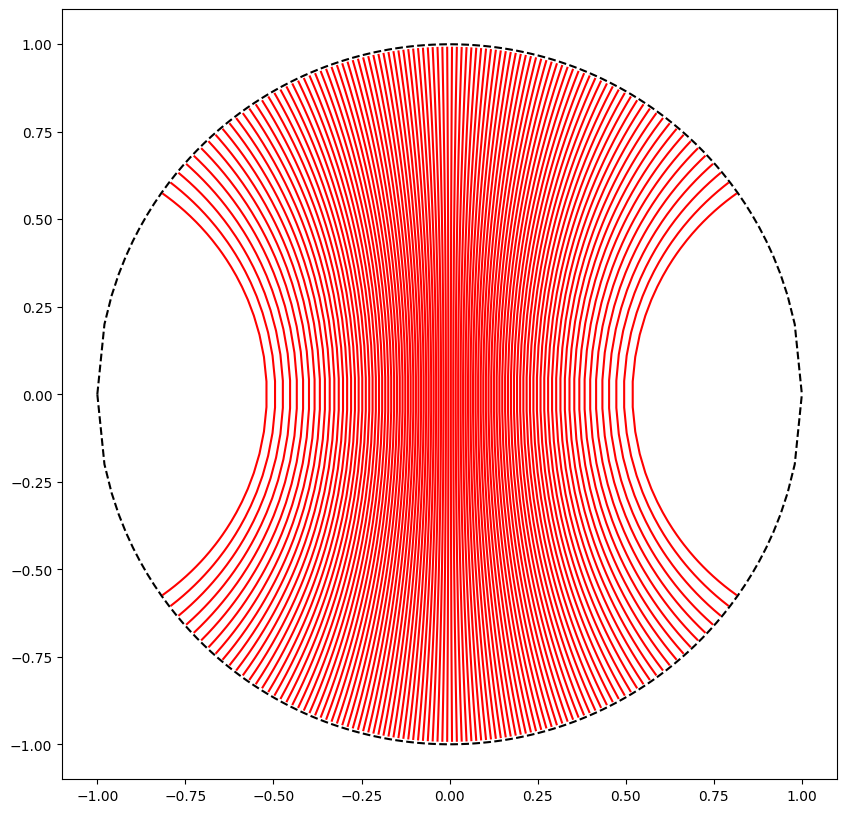

In [146]:
# Quick sanity check on plot_boundary code:

fig, ax = plt.subplots(figsize=(10, 10))
for theta in thetas:
    ax = plot_boundary(1, theta, ax=ax)
_x = np.linspace(-1, 1, 100)
_y = np.sqrt(1 - _x ** 2)
ax.plot(_x, _y, "k--")
ax.plot(_x, -_y, "k--")
plt.show()


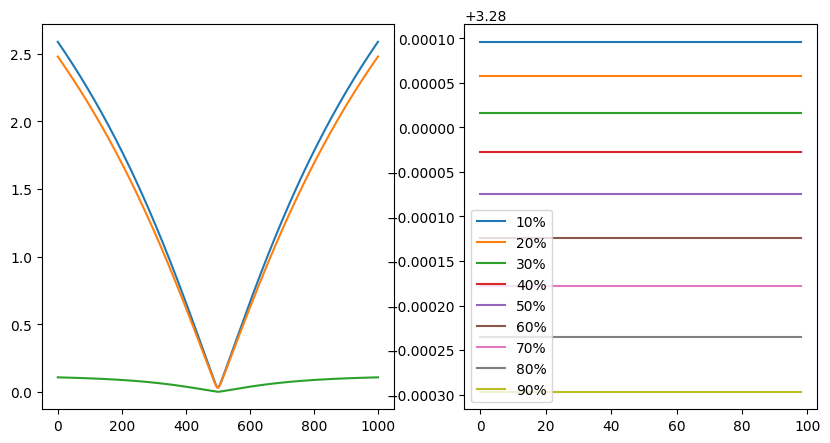

In [151]:
# The main loop:

dists = {i: [] for i in range(10, 100, 10)}  # Every 10
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for i in range(len(thetas) - 1):
    theta_1 = thetas[i]
    theta_2 = thetas[i + 1]
    geodesic_1 = geodesics[i]
    geodesic_2 = geodesics[i + 1]

    midpoint = (theta_1 + theta_2) / 2
    geodesic_m = _get_geodesic(
        dim=1, theta=midpoint, geometry="hyperboloid", t_dim=2
    )

    dists_1_m = [
        manifold.metric.dist(g1, gm) for g1, gm in zip(geodesic_1, geodesic_m)
    ]
    dists_2_m = [
        manifold.metric.dist(g2, gm) for g2, gm in zip(geodesic_2, geodesic_m)
    ]

    if i == 0:
        ax[0].plot(dists_1_m, label="d1")
        ax[0].plot(dists_2_m, label="d2")
        ax[0].plot(
            np.abs(np.array(dists_1_m) - np.array(dists_2_m)), label="diff"
        )
    for i in range(10, 100, 10):
        dists[i].append(np.abs(dists_1_2[i] - dists_2_3[i]))

for i in range(10, 100, 10):
    ax[1].plot(dists[i], label=f"{i}%")
ax[1].legend()

# So basically we see that:
# 1. Distance aberration depends on where on the arc we are
# 2. Distance aberration does NOT depend on the specific values of the thetas


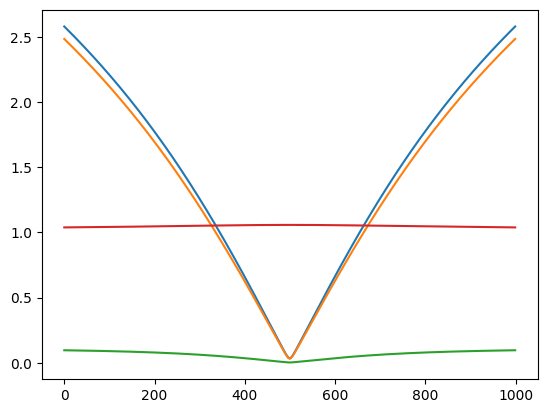

In [161]:
# Model system: geodesics 1, 2:

th1 = thetas[0]
th2 = thetas[1]

# midpoint = (th1 + th2) / 2 # Euclidean mean
# midpoint = np.arctan2(np.sin(th1) + np.sin(th2), np.cos(th1) + np.cos(th2)) # Riemannian mean
# midpoint = np.arctanh(np.tanh(th1) + np.tanh(th2))  # Hyperbolic mean
midpoint = np.sqrt(th1 * th2)  # Lorentzian mean
mid_geodesic = _get_geodesic(
    dim=1, theta=midpoint, geometry="hyperboloid", t_dim=2
)

dists_1_m = np.array(
    [manifold.metric.dist(g1, gm) for g1, gm in zip(geodesics[0], mid_geodesic)]
)
dists_2_m = np.array(
    [manifold.metric.dist(gm, g3) for gm, g3 in zip(geodesics[1], mid_geodesic)]
)

plt.plot(dists_1_m, label="1-3")
plt.plot(dists_2_m, label="2-3")
plt.plot(dists_1_m - dists_2_m, label="diff")
plt.plot(dists_1_m / dists_2_m, label="ratio")


In [173]:
# Can I find a theta that minimizes the distance aberration?


def minimize_distance_aberration(theta_1, theta_2, dim=2, timelike_dim=0):
    """Find the theta that minimizes the distance aberration between two points"""
    geodesic_1 = _get_geodesic(
        dim, theta_1, timelike_dim=timelike_dim, geometry="hyperboloid"
    )
    geodesic_2 = _get_geodesic(
        dim, theta_2, timelike_dim=timelike_dim, geometry="hyperboloid"
    )

    min_theta = np.min([theta_1, theta_2])
    max_theta = np.max([theta_1, theta_2])

    best_score = np.inf
    best_theta = None
    best_geodesic = None
    for theta in np.linspace(min_theta, max_theta, 100):
        geodesic_m = _get_geodesic(
            dim, theta, timelike_dim=timelike_dim, geometry="hyperboloid"
        )
        dist1 = np.array(
            [
                manifold.metric.dist(g1, gm)
                for g1, gm in zip(geodesic_1, geodesic_m)
            ]
        )
        dist2 = np.array(
            [
                manifold.metric.dist(g2, gm)
                for g2, gm in zip(geodesic_2, geodesic_m)
            ]
        )
        score = np.sum(np.abs(dist1 - dist2))
        if score < best_score:
            best_score = score
            best_theta = theta
            best_geodesic = geodesic_m

    print("Best score:", best_score)

    return best_theta, best_geodesic


best_theta, best_geodesic = minimize_distance_aberration(
    , theta_2, dim=2, timelike_dim=0
)


Best score: 3.619171663596278


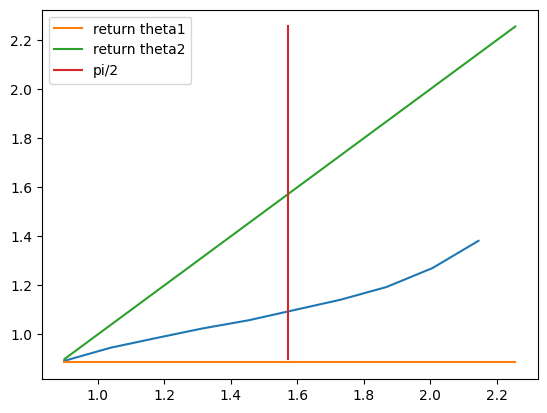

In [198]:
# Plot best theta as a function of theta_2

# best_thetas = [
#     minimize_distance_aberration(thetas[0], t2, dim=2, timelike_dim=0)[0]
#     for t2 in thetas[1:100:10]
# ]
plt.plot(thetas[1:100:10], best_thetas)
plt.plot([thetas[1], thetas[99]], [thetas[0]] * 2, label="return theta1")
plt.plot(
    [thetas[1], thetas[99]], [thetas[1], thetas[99]], label="return theta2"
)
plt.plot([np.pi / 2] * 2, [thetas[1], thetas[99]], label="pi/2")
plt.legend()


# Where does theta hit on the hyperboloid?

I think we're getting muddled by talking about geodesics. Let's consider just a cross-section of the hyperbola in the plane
where all dimensions outside of $x_D, x_0$ are 0. The remaining variables have a simple relationship:
$$
x_D^2 - x_0^2 = -1
$$

Additionally, we would like to have that 
$$
x_0 = a\sin(\theta)\\
x_D = a\cos(\theta)
$$

Notice that, for a fixed theta, this is a single-variable problem: we only have to solve for $a$. Let's do this now:
$$
\begin{align*}
x_D^2 - x_0^2 &= -1\\
x_D^2 &= -1 + x_0^2\\
a^2\cos^2(\theta) &= -1 + a^2\sin^2(\theta)\\
a^2(\cos^2(\theta) - \sin^2(\theta))  &= -1\\
a^2 &= \frac{-1}{\cos^2(\theta) - \sin^2(\theta)}\\
a^2 &= \frac{-1}{\cos(2\theta)} \text{ (double angle formula)}\\
a^2 &= -\sec(2\theta)\\
a & = \sqrt{-\sec(2\theta)}
\end{align*}
$$

Finally, we can plug our $a$ back into the equations to determine that, for any $\theta$, our plane intersects this hyperboloid at
$$
x_0 = \sqrt{-\sec(2\theta)}\sin(\theta)\\
x_D = \sqrt{-\sec(2\theta)}\cos(\theta)
$$

Let's show this with a toy example (a 2-D plot):

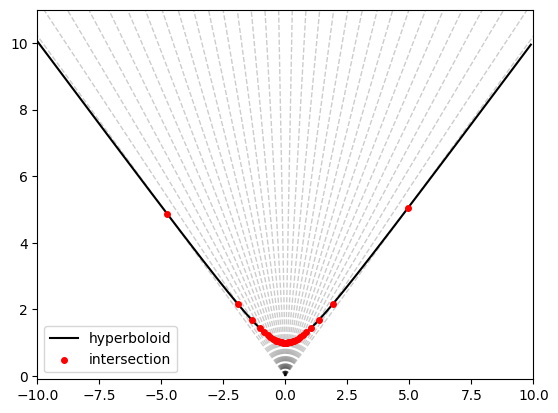

In [277]:
# Show that x0 = sqrt(-sec(2theta)sin(theta)), xD = sqrt(-sec(2theta)cos(theta))
# is a solution to the hyperboloid equation:

_xD = np.arange(-10, 10, 0.1)
_x0 = np.sqrt(1 + _xD ** 2)
plt.plot(_xD, _x0, color="black", label="hyperboloid")  # Flip x,y

_a = np.arange(0, 20, 0.1)

thetas = np.arange(np.pi / 4 + 0.01, 3 * np.pi / 4 - 0.01, 0.05)
intersections = []
for theta in thetas:
    a = np.sqrt(-1 / np.cos(2 * theta))  # -sec(2 theta)^(1/2)
    intersections.append((a * np.sin(theta), a * np.cos(theta)))
    plt.plot(
        _a * np.cos(theta),
        _a * np.sin(theta),  # Flip x,y
        color="black",
        linestyle="--",
        lw=1,
        alpha=0.2,
    )
intersections = np.array(intersections)
plt.scatter(
    intersections[:, 1],
    intersections[:, 0],
    color="red",
    label="intersection",
    s=16,
    zorder=3,
)  # Flip x,y

plt.ylim(-0.1, 11)
plt.xlim(-10, 10)
plt.legend()
plt.show()
